This notebook follows on from load_matlab_icesat1_structures.ipynb, and plots icesat lines over the channel

In [3]:
import h5py
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from shapely.ops import nearest_points
import numpy as np

In [10]:
def icesat1todataframe(track):
    """
    this function will import the .mat and arrange into a dataframe
    track = eg track
    """
    
    
    
    path = f'/Volumes/arc_01/horganhu/ICESAT/GLA12_633_TRACKS/{track}_processed.mat'
    df = pd.DataFrame({'x':[],
                       'pass_num':[],
                      })
    psys = []
    h = []
    UTCtime = []
    dh = []

    with h5py.File(path, 'r') as f:
        #add x location
        psx_l = list(f['antarctica'][track]['psx'])
        for p in psx_l:
            df_temp = pd.DataFrame({'x': list(f['antarctica'][track]['psx'][p][0]),
                                    'pass_num': [p]*len(list(f['antarctica'][track]['psx'][p])[0]) })
            df = df.append(df_temp , ignore_index=True )

        #add y location
        psy_l = list(f['antarctica'][track]['psy'])
        for p in psy_l:
            psys.extend( list(f['antarctica'][track]['psy'][p][0]) )

        #add height
        h_l = list(f['antarctica'][track]['elev_wgs84_retide'])
        for p in h_l:
            h.extend( list(f['antarctica'][track]['elev_wgs84_retide'][p][0]) )

        #add time
        t_l = list(f['antarctica'][track]['UTCTime'])
        for p in t_l:
            UTCtime.extend( list(f['antarctica'][track]['UTCTime'][p][0]) )

        #add delta_h (not sure what it is)
        dh_l = list(f['antarctica'][track]['delta_h'])
        for p in dh_l:
            dh.extend( list(f['antarctica'][track]['delta_h'][p][0]) )

    df['y'] = psys
    df['h'] = h
    #convert Icesat1 UTCtime to a datetime64 object. 2000-1-1 12:00 is icesat epoch beginning, 1970-1-1 00:00 is that for POSIX, the utcfromtimestamp function
    df['time'] = [pd.Timestamp.utcfromtimestamp(t)+ (pd.Timestamp(2000,1,1,12) - pd.Timestamp(1970,1,1))
                  for t in UTCtime]
    df['delta_h'] = dh

    da = df.query("x > -382064.5722209641 & x < -374781.1654740692 & y > -734075.0820404041 & y < -722764.4514729496")
    da.reset_index(drop=True,inplace=True)
    
    points = [Point(xy) for xy in zip(da.x,da.y)]
    gda = gpd.GeoDataFrame(da,geometry=points,crs=3031)
    
    return gda

### from load_matlab_icesat1_structures we see the tracks over the channel with  the most data
track number_of_datapoints
track0015 0
track1331 68
track0043 0
track0197 68
track1303 68
track0351 68
track0057 0
track0407 68
track0155 68
track0127 68
track0183 68
track0365 68
track0337 68
track0099 753
track0295 68
track0323 68
track0211 549
track0113 68
track0379 68
track0085 193
track0267 68
track0071 0
track0169 68
track1289 68
track0029 0
track1345 68
track0239 68
track1275 68
track0225 68
track0001 0
track0393 68
track0141 68
track0253 68
track0309 68
track1317 68
track0281 68

In [43]:
def mapthelines(df):
    melt = Point(-380650, -725450)
    accr = Point(-377950,-729050)
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    plt.figure(figsize=(10,10))
    for pas in df.pass_num.value_counts().index.tolist():
        dl = df[df.pass_num==pas]
        plt.plot(dl.x,dl.y,'1',label=dl.time.mean().strftime('%Y-%m-%d'))
    plt.plot(melt.x,melt.y,'^',label='melt centre')
    plt.plot(accr.x,accr.y,'s',label='accretion centre')
    plt.plot(gd_chan.iloc[75:-300:15].geometry.x,gd_chan.iloc[75:-300:15].geometry.y,'g:',label='surface channel low')
    plt.xlim([-382064.5722209641,-374781.1654740692])
    plt.ylim([-734075.0820404041 , -722764.4514729496])
    plt.legend()
    
    plt.grid()
    
def plotcrosssection(df):
    gd_chan = gpd.read_file("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RES/PROCESSED_LINES_GISFILE/linedownchan.shp")
    plt.figure(figsize=(15,6))
#     mins and maxs to get figure span
    mins = []
    maxs = []
    for pas in df.pass_num.value_counts().index.tolist():
        #make new column of along track distance
        dl = df[df.pass_num==pas].copy()
        #temp distance from previous
        tmp_dx = [Point.distance(dl.geometry.iloc[i]) for i,Point in enumerate(dl.geometry.iloc[1:])] #note the 1:, equivalent to i+1
        tmp_dx[:0] = [0]
        dl['dx'] = tmp_dx
        dl['distance_cum'] = dl.dx.cumsum().to_numpy()
         #zero it at the channel, first find the point closest to the channel
        nearest_icesat_pt,nearest_chan_pt = nearest_points(dl.geometry.unary_union,gd_chan.geometry.unary_union)
        i = df[df.x==nearest_icesat_pt.x].index[0]
        dl['distance_cum'] = dl['distance_cum'].to_numpy() - dl.distance_cum.loc[i]
        mins.append(dl.distance_cum.min())
        maxs.append(dl.distance_cum.max())
        plt.plot(dl.distance_cum,dl.h,'x',label=dl.time.mean().strftime('%Y-%m-%d'))
    
    plt.xlim([np.median(np.array(mins)),np.median(np.array(maxs))])
    plt.legend()
    plt.grid()

# Check out track0099

In [41]:
df0099 = icesat1todataframe('track0099')

In [2]:
df0099.time.mean().date()

NameError: name 'df0099' is not defined

In [39]:
df0099.time.mean().strftime('%Y-%m-%d')

'2006-09-14'

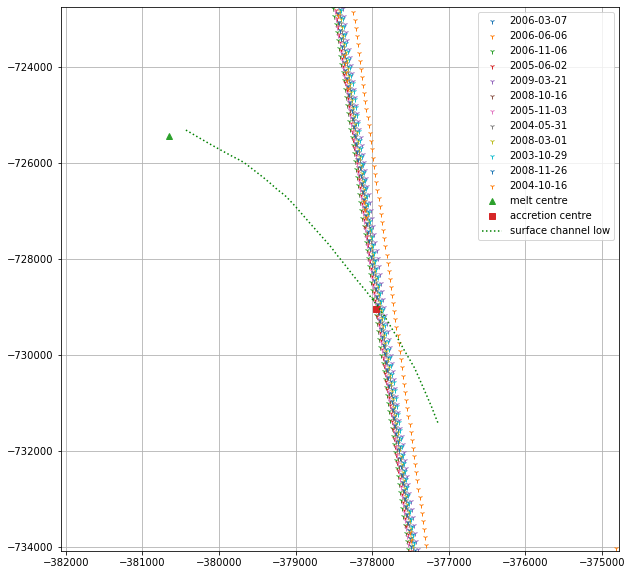

In [44]:
mapthelines(df0099)

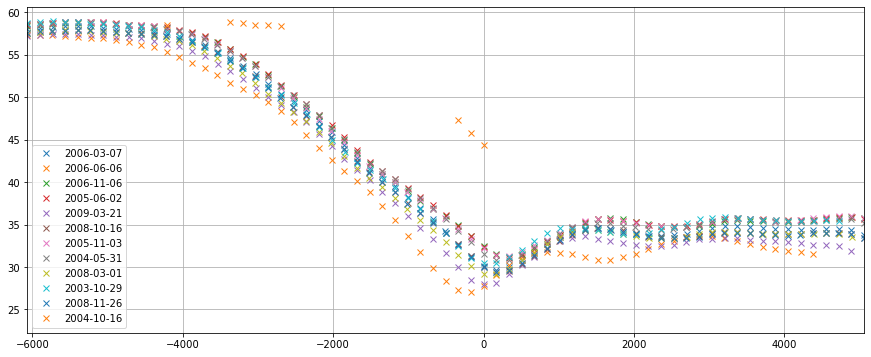

In [45]:
plotcrosssection(df0099)

# Check out track0211

In [46]:
df0211 = icesat1todataframe('track0211')

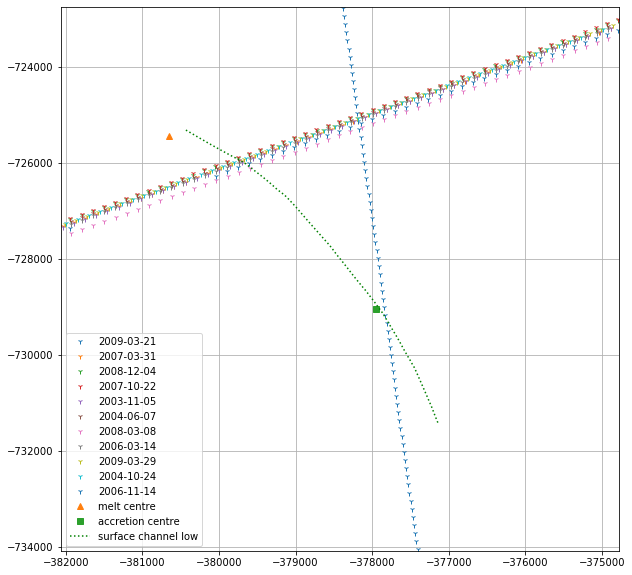

In [47]:
mapthelines(df0211)

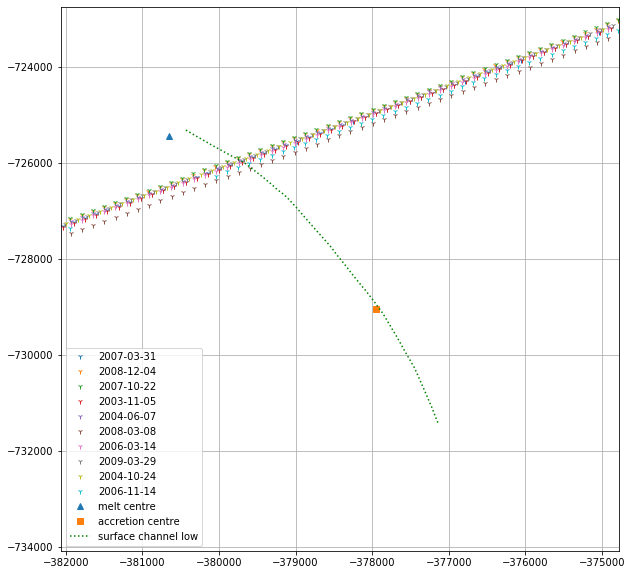

In [48]:
#drop the rogue line
df0211 = df0211[df0211.pass_num !='psxPass23']
mapthelines( df0211)

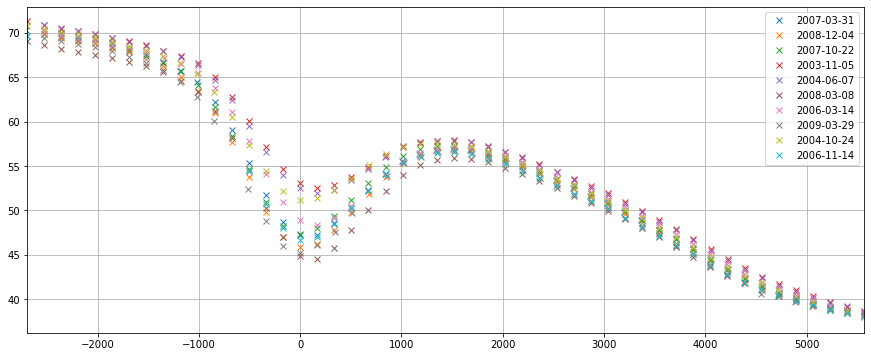

In [49]:
plotcrosssection(df0211)

# Check out track0085

In [50]:
track0085 = icesat1todataframe('track0085')

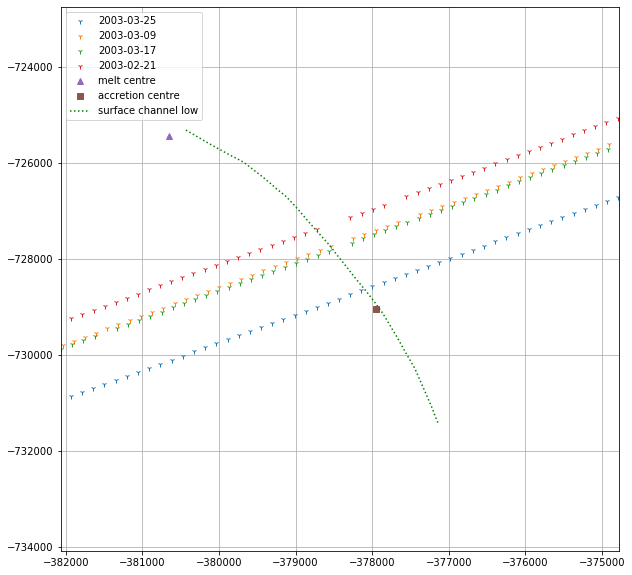

In [51]:
mapthelines(track0085)

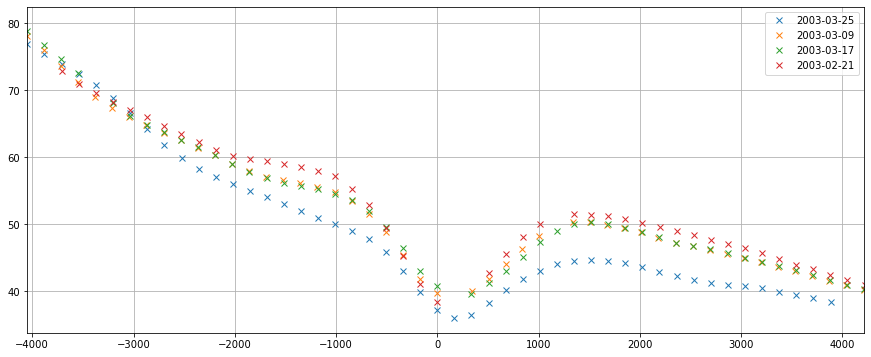

In [52]:
plotcrosssection(track0085)

# Check out track0099

In [53]:
df0099 = icesat1todataframe('track1331')

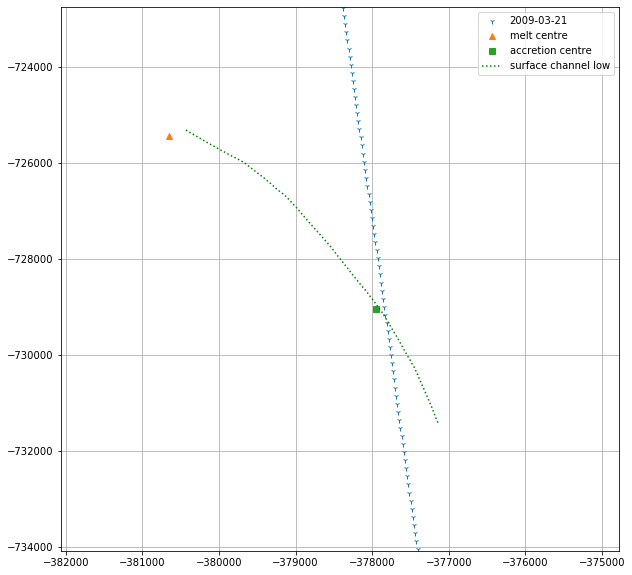

In [54]:
mapthelines(df0099)

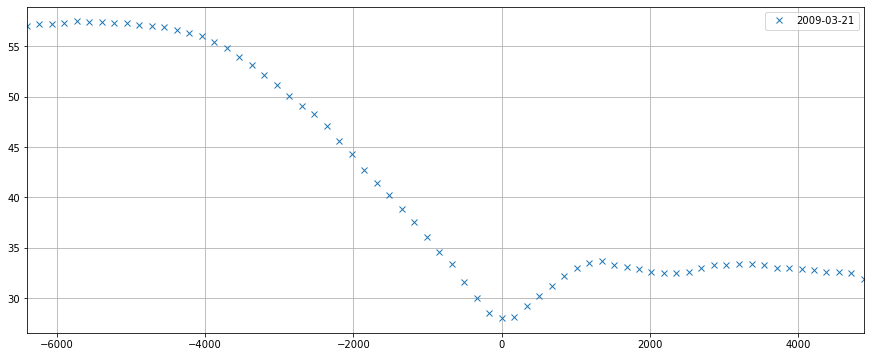

In [55]:
plotcrosssection(df0099)

## problems
There seems to be some errors in labelling, either in the data or my upload.  This rogues psxPass23 keeps showing up

In [56]:
df1317 = icesat1todataframe('track1317')

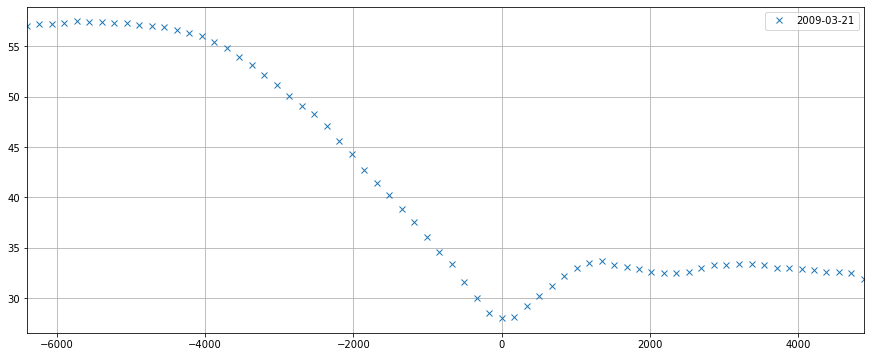

In [57]:
plotcrosssection(df1317)